Computational notebooks allow users to interleave text, code, and results in a single document. This notebook first demonstrates a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values. The Jupyter notebook allows us to express that mathematically, using the typesetting language $\LaTeX{}$: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

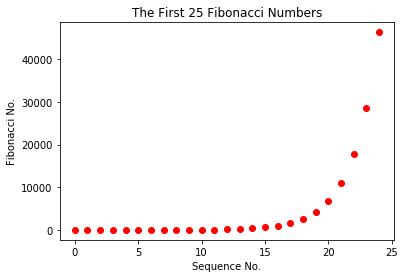

In [4]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

Anything you can do programmatically, can be documented in a notebook. Here we'll add an interactive map, just as in our June [mapping feature](https://www.nature.com/articles/d41586-018-05331-6). This requires the Python Leaflet library, folium. (**Uncomment the following cell if you don't have folium already installed.**)

In [5]:
# !pip install folium

In [6]:
import folium

Now we create a simple map: a few points in London, Oxford and Cambridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). (Click the tiles icon in the upper-right corner of the map to switch between the two layers.)

In [7]:
import pandas as pd

# create a data frame of locations
name = ["Nature", "Francis Crick Institute", "University College London", 
        "MRC Laboratory for Molecular Cell Biology", "Kings College London",
       "Imperial College London", "Cambridge University", "Oxford University",
       "Platform 9-3/4"]
lat = [51.533925,51.531877,51.524486,51.524435,51.511573,51.498780,52.206960,51.754843,51.532349]
long = [-0.121553,-0.128767,-0.133997,-0.132495,-0.116083,-0.174888,0.115034,-1.254302,-0.123806]

df = pd.DataFrame({'Name': name, 'Lat': lat, 'Long': long})

In [8]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for index,row in df.iterrows():
    folium.CircleMarker(
    location=[row['Lat'], row['Long']],
    popup=row['Name'],
    color=('crimson' if row['Name'] == 'Nature' else 'blue'),
    fill=False,
    ).add_to(m)

folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map.

In [9]:
m

Collect session info, for [computational reproducibility](https://www.nature.com/articles/d41586-018-05990-5)!

In [10]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.7.0-x86_64-i386-64bit',
 'sys_executable': '/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.3 | packaged by conda-forge | (default, Oct  5 2017, '
                '19:18:17) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'}


In [11]:
!pip freeze | grep -E 'folium|matplotlib|pandas'

folium==0.6.0
matplotlib==2.1.0
pandas==0.20.3
